In [1]:
# Import libraries to start working

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Load data for CD45 
cd1 = pd.read_csv("/Users/luizmaniero/Documents/DataScience/HMRI_IHC_colab/20250504_CD45_results/cd45_Results_20250504.csv")
cd2 = pd.read_csv("/Users/luizmaniero/Documents/DataScience/HMRI_IHC_colab/20250701_CD45_results/cd45_Nuclei_count_20250107.csv")

# Load data for bGAL 
bg1 = pd.read_csv("/Users/luizmaniero/Documents/DataScience/HMRI_IHC_colab/20250503_bGAL_results/bGAL_Results_20250503.csv")
bg2 = pd.read_csv("/Users/luizmaniero/Documents/DataScience/HMRI_IHC_colab/20250701_bGAL_results/bGAL_Nuclei_count_20250107.csv")



In [4]:
# === 1. Extract the common image ID from filenames ===
cd1['ImageID'] = cd1['Label'].str.extract(r'(Image_CD45_.*?_crop_\d)')
cd2['ImageID'] = cd2['Slice'].str.extract(r'(Image_CD45_.*?_crop_\d)')
bg1['ImageID'] = bg1['Label'].str.extract(r'(Image_B_Gal_.*?_crop_\d)')
bg2['ImageID'] = bg2['Slice'].str.extract(r'(Image_B_Gal_.*?_crop_\d)')

# === 2. Merge on the extracted ID ===
merged_cd = pd.merge(cd1, cd2, on='ImageID', how='inner', suffixes=('_cd45', '_nuclei'))
merged_bg = pd.merge(bg1, bg2, on='ImageID', how='inner', suffixes=('_bGAL', '_nuclei'))

# === 3. Save or display the result ===
#merged_cd.to_csv("merged_cd45.csv", index=False)
#merged_bg.to_csv("merged_bGAL.csv", index=False)

In [5]:
# === Select columns from merged df ===
cd_m = merged_cd[['ImageID', 'Count', 'RawIntDen']]
bg_m = merged_bg[['ImageID', 'Count', 'RawIntDen']]

# === Calculate normalized intensity diving by total nuclei per image ===
cd_m['Normalized'] = (cd_m['RawIntDen']/cd_m['Count']).round(2)
bg_m['Normalized'] = (bg_m['RawIntDen']/bg_m['Count']).round(2)

# === Add SAMPLE column to identify each group of images ===
cd_m['SAMPLE'] = cd_m['ImageID'].str.extract(r'_CD45_([A-Za-z0-9]+)_')[0]
bg_m['SAMPLE'] = bg_m['ImageID'].str.extract(r'_B_Gal_([A-Za-z0-9]+)_')[0]


/var/folders/fk/3y6t2wps21bb7h_0r4p99ccc0000gn/T/ipykernel_17730/1024638272.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_m['Normalized'] = (cd_m['RawIntDen']/cd_m['Count']).round(2)
/var/folders/fk/3y6t2wps21bb7h_0r4p99ccc0000gn/T/ipykernel_17730/1024638272.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_m['Normalized'] = (bg_m['RawIntDen']/bg_m['Count']).round(2)
/var/folders/fk/3y6t2wps21bb7h_0r4p99ccc0000gn/T/ipykernel_17730/1024638272.py:10: SettingWithCopyWarning: 
A value is trying to

In [6]:
# === Load metadata to identify each group of images ===
mt = pd.read_csv("/Users/luizmaniero/Documents/DataScience/HMRI_IHC_colab/mouse_metadata.csv")

# === Merge based on SAMPLE ===
cd_mt = pd.merge(cd_m, mt, on='SAMPLE', how='left')
bg_mt = pd.merge(bg_m, mt, on='SAMPLE', how='left')



In [7]:
# === Check for NA in sample and group columns ===
print(cd_mt[['SAMPLE', 'GROUP']].isna().sum())
print(bg_mt[['SAMPLE', 'GROUP']].isna().sum())




SAMPLE    0
GROUP     6
dtype: int64
SAMPLE    0
GROUP     3
dtype: int64


In [8]:
# === Drop NA
cd_mt = cd_mt.dropna(subset=['GROUP'])
bg_mt = bg_mt.dropna(subset=['GROUP'])

print(cd_mt[['SAMPLE', 'GROUP']].isna().sum())
print(bg_mt[['SAMPLE', 'GROUP']].isna().sum())

SAMPLE    0
GROUP     0
dtype: int64
SAMPLE    0
GROUP     0
dtype: int64


In [9]:
# Replace inf and -inf with NaN first
cd_mt['Normalized'].replace([np.inf, -np.inf], np.nan, inplace=True)
bg_mt['Normalized'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Then replace NaN with 0
cd_mt['Normalized'].fillna(0, inplace=True)
bg_mt['Normalized'].fillna(0, inplace=True)

/var/folders/fk/3y6t2wps21bb7h_0r4p99ccc0000gn/T/ipykernel_17730/306685794.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cd_mt['Normalized'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/fk/3y6t2wps21bb7h_0r4p99ccc0000gn/T/ipykernel_17730/306685794.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

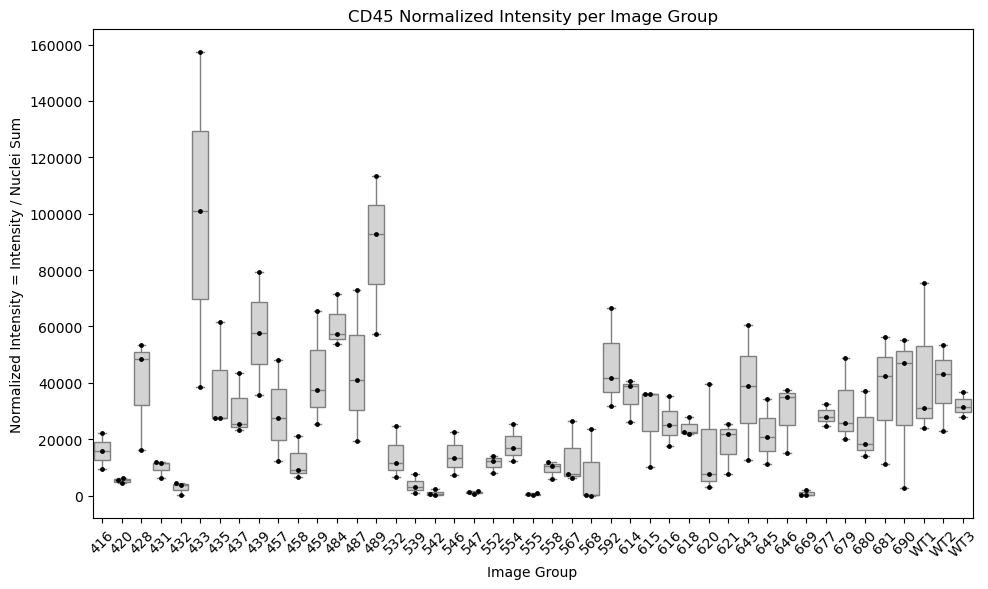

In [10]:
plt.figure(figsize=(10, 6))

# Boxplot for CD45
sns.boxplot(x='SAMPLE', y='Normalized', data=cd_mt, color='lightgray', showfliers=False)
sns.swarmplot(x='SAMPLE', y='Normalized', data=cd_mt, color='black', size=3.5)

plt.xlabel('Image Group')
plt.ylabel('Normalized Intensity = Intensity / Nuclei Sum')
plt.title('CD45 Normalized Intensity per Image Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

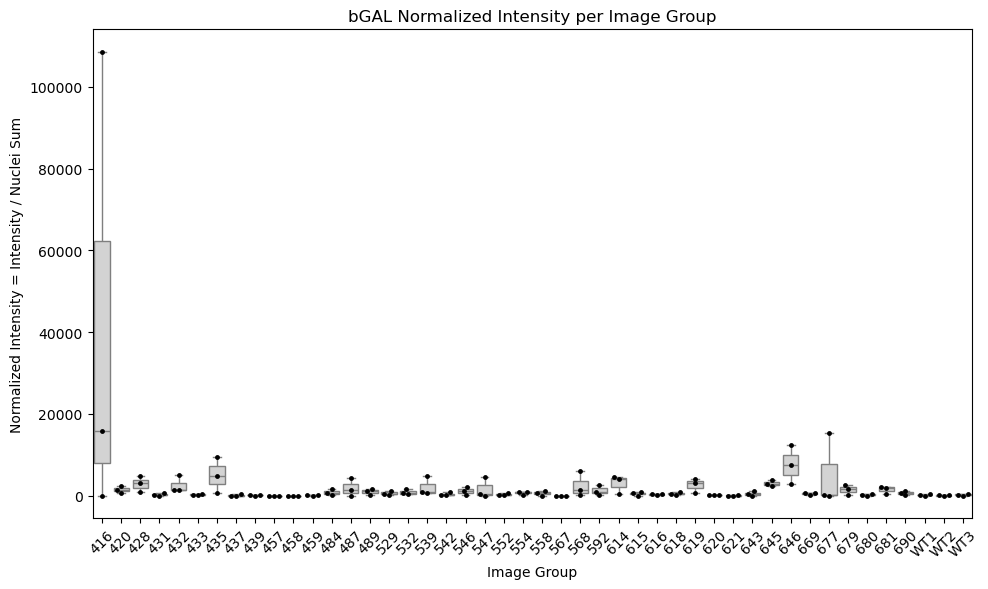

In [11]:
plt.figure(figsize=(10, 6))

# Boxplot for bGAL
sns.boxplot(x='SAMPLE', y='Normalized', data=bg_mt, color='lightgray', showfliers=False)
sns.swarmplot(x='SAMPLE', y='Normalized', data=bg_mt, color='black', size=3.5)

plt.xlabel('Image Group')
plt.ylabel('Normalized Intensity = Intensity / Nuclei Sum')
plt.title('bGAL Normalized Intensity per Image Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# === 4. Save or display the result ===
cd_mt.to_csv("20250710_cd45_normalized.csv", index=False)
# === 4. Save or display the result ===
bg_mt.to_csv("20250710_bGAL_normalized.csv", index=False)

In [13]:
# Statistical test for CD45, based on groups
import scipy.stats as stats

# Group data by GROUP
cd_mt_grouped = cd_mt.groupby('GROUP')['Normalized'].apply(list)

# Run Kruskal–Wallis test, because data distribution is not normal, use median instead of mean values
stat, p = stats.kruskal(*cd_mt_grouped)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.3g}")


Kruskal-Wallis H-statistic = 19.334, p-value = 0.00167


In [14]:
cd_mt_grouped

GROUP
PRG         [12606.27, 38786.38, 60351.85, 34359.19, 11043...
PRG eLNP    [53343.57, 48303.38, 16137.07, 43561.7, 25380....
PRG mLNP    [22185.0, 9282.0, 15710.83, 4456.96, 3796.67, ...
WT          [31.88, 360.73, 2135.08, 25858.38, 48899.61, 1...
WT eLNP     [4274.29, 5551.15, 6138.55, 11849.36, 11557.12...
WT mLNP     [967.01, 7502.37, 3108.57, 13151.82, 22657.22,...
Name: Normalized, dtype: object

In [15]:
print(cd_mt[['Normalized', 'GROUP']].isna().sum())

#df_clean = df_merg.dropna(subset=['Normalized', 'GROUP'])

Normalized    0
GROUP         0
dtype: int64


In [16]:
print(cd_mt['GROUP'])

0      PRG mLNP
1      PRG mLNP
2      PRG mLNP
3       WT eLNP
4       WT eLNP
         ...   
136          WT
137          WT
138          WT
139          WT
140          WT
Name: GROUP, Length: 135, dtype: object


In [17]:
import scikit_posthocs as sp

# Dunn's test with Benjamini-Hochberg correction
cd_dunn = sp.posthoc_dunn(cd_mt, val_col='Normalized', group_col='GROUP', p_adjust='fdr_bh')


In [18]:
print(cd_dunn)

               PRG  PRG eLNP  PRG mLNP        WT   WT eLNP  WT mLNP 
PRG       1.000000  0.866817  0.880697  0.880697  0.723927  0.003019
PRG eLNP  0.866817  1.000000  0.904640  0.904640  0.904640  0.008116
PRG mLNP  0.880697  0.904640  1.000000  0.904640  0.880697  0.003019
WT        0.880697  0.904640  0.904640  1.000000  0.904640  0.008116
WT eLNP   0.723927  0.904640  0.880697  0.904640  1.000000  0.012424
WT mLNP   0.003019  0.008116  0.003019  0.008116  0.012424  1.000000


In [19]:
cd_dunn.to_csv("20250708_cd45_all_dunn_result.csv", index=False)

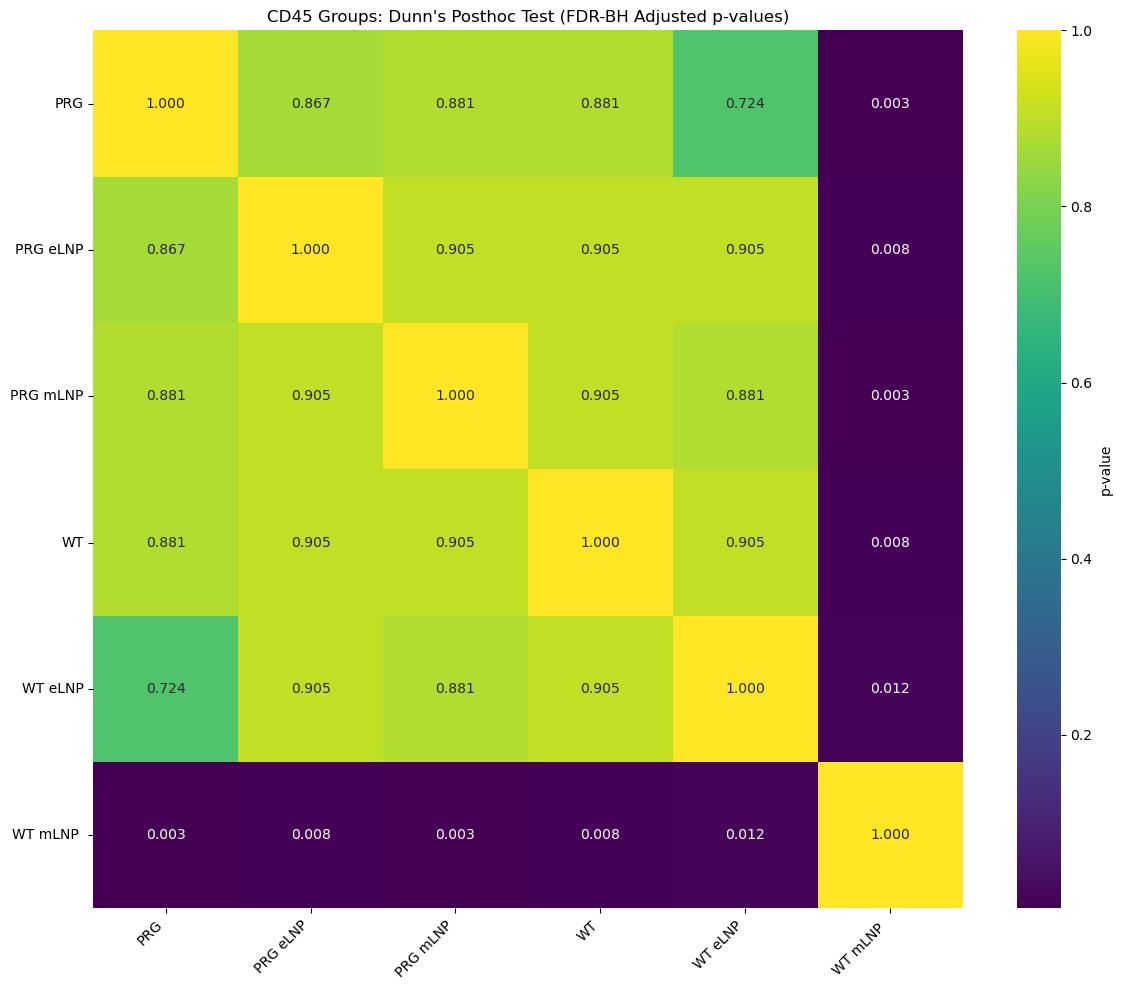

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(cd_dunn, cmap="viridis", annot=True, fmt=".3f", cbar_kws={'label': 'p-value'})
plt.title("CD45 Groups: Dunn's Posthoc Test (FDR-BH Adjusted p-values)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [2]:
# === Load your data ===
df = pd.read_csv("/Users/luizmaniero/Documents/DataScience/HMRI_IHC_colab/20250710_cd45_normalized.csv")

In [3]:
df.head()

,ImageID,Count,RawIntDen,Normalized,SAMPLE,ROUTE,INJECTIONS,GROUP
0,Image_CD45_416_-_20x_BF_05_crop_2,56,1242360,22185.00,416,IV,5.0,PRG mLNP
1,Image_CD45_416_-_20x_BF_05_crop_3,55,510510,9282.00,416,IV,5.0,PRG mLNP
2,Image_CD45_416_-_20x_BF_06_crop_1,54,848385,15710.83,416,IV,5.0,PRG mLNP
3,Image_CD45_420_-_20x_BF_06_crop_1,63,269280,4274.29,420,IV,5.0,WT eLNP
4,Image_CD45_420_-_20x_BF_06_crop_2,39,216495,5551.15,420,IV,5.0,WT eLNP


In [23]:
df['GROUP'] == 'WT mLNP'

0      False
1      False
2      False
3      False
4      False
       ...  
130    False
131    False
132    False
133    False
134    False
Name: GROUP, Length: 135, dtype: bool

In [25]:
df['GROUP'] = df['GROUP'].str.strip()

In [26]:
print(df['GROUP'].unique())


['PRG mLNP' 'WT eLNP' 'PRG eLNP' 'WT mLNP' 'PRG' 'WT']


In [28]:
import pandas as pd

# Define custom order
group_order = ["WT", "WT eLNP", "WT mLNP", "PRG", "PRG eLNP", "PRG mLNP"]

# Apply category ordering
df["GROUP"] = pd.Categorical(df["GROUP"], categories=group_order, ordered=True)


/var/folders/fk/3y6t2wps21bb7h_0r4p99ccc0000gn/T/ipykernel_13861/367693411.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(
/var/folders/fk/3y6t2wps21bb7h_0r4p99ccc0000gn/T/ipykernel_13861/367693411.py:31: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


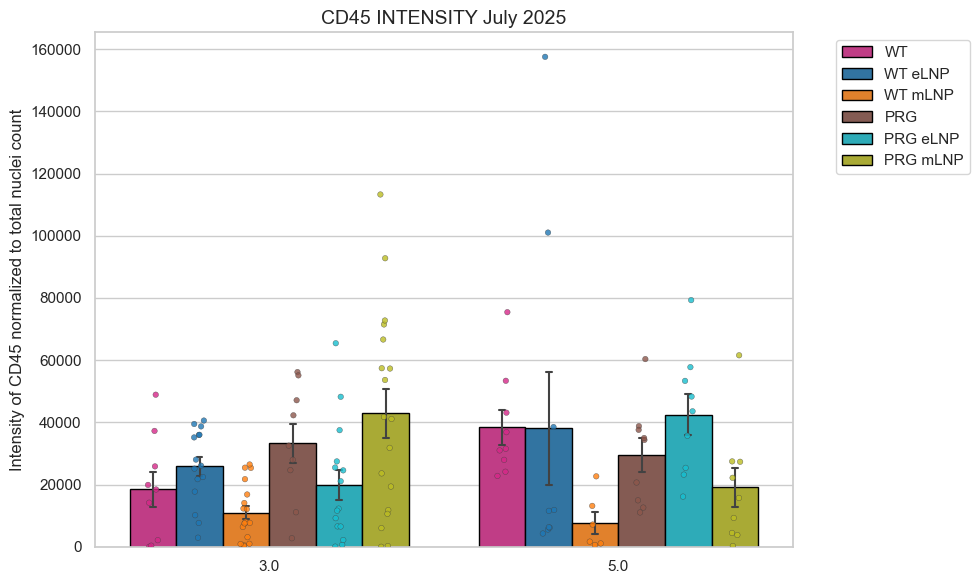

In [41]:

# === Set up the plot ===
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# === Define color palette for consistency ===
palette = {
    "WT": "#d62788",          # pink
    "WT eLNP": "#1f77b4",    # blue
    "WT mLNP": "#ff7f0e",    # orange
    "PRG": "#8c564b",         # brown
    "PRG eLNP": "#17becf",   # cyan
    "PRG mLNP": "#bcbd22",   # yellow-green
}

# === Plot ===

ax = sns.barplot(
    data=df,
    x="INJECTIONS",
    y="Normalized",
    hue="GROUP",
    hue_order=group_order,
    palette=palette,
    errorbar="se",         # show standard error
    edgecolor='black',
    errwidth=1.5,
    capsize=0.1
)

# Overlay swarm (dot) plot
sns.stripplot(
    data=df,
    x="INJECTIONS",
    y="Normalized",
    hue="GROUP",
    hue_order=group_order,
    dodge=True,
    palette=palette,
    marker="o",
    size=4,
    jitter=0.1,
    linewidth=0.3,
    edgecolor="gray",
    alpha=0.8,
    ax=ax
)

# === Adjust legend ===
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:6], labels[:6], title="", bbox_to_anchor=(1.05, 1), loc='upper left')

# === Labels and title ===
plt.title("CD45 INTENSITY July 2025", fontsize=14)
plt.ylabel("Intensity of CD45 normalized to total nuclei count")
plt.xlabel("")

# === Layout fix ===
plt.tight_layout()
plt.show()


In [21]:

cd_3mo = cd_mt[cd_mt['INJECTIONS'] == 3.0]


In [22]:
cd_3mo.head(10)

,ImageID,Count,RawIntDen,Normalized,SAMPLE,ROUTE,INJECTIONS,GROUP
27,Image_CD45_457_-_20x_BF_03_crop_1,55,674985,12272.45,457,IV,3.0,PRG eLNP
28,Image_CD45_457_-_20x_BF_03_crop_2,30,1446870,48229.00,457,IV,3.0,PRG eLNP
29,Image_CD45_457_-_20x_BF_03_crop_3,33,906015,27455.00,457,IV,3.0,PRG eLNP
30,Image_CD45_458_-_20x_BF_03_crop_1,43,906780,21087.91,458,IV,3.0,PRG eLNP
31,Image_CD45_458_-_20x_BF_03_crop_2,35,322320,9209.14,458,IV,3.0,PRG eLNP
32,Image_CD45_458_-_20x_BF_03_crop_3,52,341445,6566.25,458,IV,3.0,PRG eLNP
33,Image_CD45_459_-_20x_BF_02_crop_1,33,2159595,65442.27,459,IV,3.0,PRG eLNP
34,Image_CD45_459_-_20x_BF_02_crop_2,32,815235,25476.09,459,IV,3.0,PRG eLNP
35,Image_CD45_459_-_20x_BF_02_crop_3,34,1275000,37500.00,459,IV,3.0,PRG eLNP
36,Image_CD45_484_-_20x_BF_01_crop_1,49,2808060,57307.35,484,IV,3.0,PRG mLNP


In [23]:
cd_3mo.to_csv("20250710_3mo_cd45_normalized.csv", index=False)

In [24]:
# Statistical test for CD45 3 months based on groups
import scipy.stats as stats

# Group data by GROUP
cd_3mo_grouped = cd_3mo.groupby('GROUP')['Normalized'].apply(list)

# Run Kruskal–Wallis test, because data distribution is not normal, use median instead of mean values
stat, p = stats.kruskal(*cd_3mo_grouped)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.3g}")

Kruskal-Wallis H-statistic = 17.395, p-value = 0.00381


In [25]:
import scikit_posthocs as sp

# Dunn's test with Benjamini-Hochberg correction
cd_3mo_dunn = sp.posthoc_dunn(cd_3mo, val_col='Normalized', group_col='GROUP', p_adjust='fdr_bh')


In [26]:
print(cd_3mo_dunn)

               PRG  PRG eLNP  PRG mLNP        WT   WT eLNP  WT mLNP 
PRG       1.000000  0.194651  0.968849  0.194651  0.596369  0.032708
PRG eLNP  0.194651  1.000000  0.114189  0.957249  0.339171  0.339171
PRG mLNP  0.968849  0.114189  1.000000  0.139229  0.510037  0.006017
WT        0.194651  0.957249  0.139229  1.000000  0.339171  0.503293
WT eLNP   0.596369  0.339171  0.510037  0.339171  1.000000  0.054289
WT mLNP   0.032708  0.339171  0.006017  0.503293  0.054289  1.000000


In [27]:
cd_3mo_dunn.to_csv("20250708_cd45_3mo_dunn_result.csv", index=False)

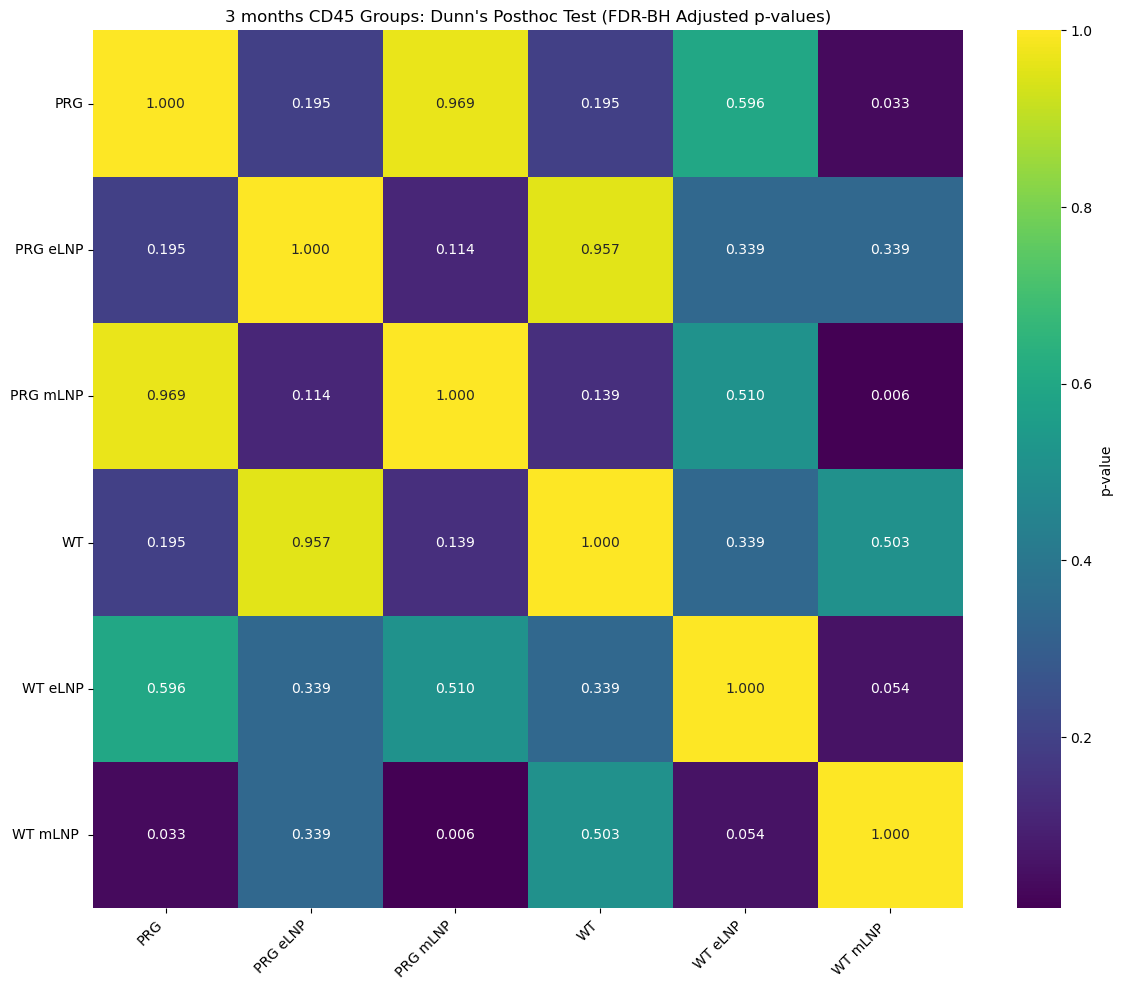

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(cd_3mo_dunn, cmap="viridis", annot=True, fmt=".3f", cbar_kws={'label': 'p-value'})
plt.title("3 months CD45 Groups: Dunn's Posthoc Test (FDR-BH Adjusted p-values)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
cd_5mo = cd_mt[cd_mt['INJECTIONS'] == 5.0]
cd_5mo.head(10)


,ImageID,Count,RawIntDen,Normalized,SAMPLE,ROUTE,INJECTIONS,GROUP
0,Image_CD45_416_-_20x_BF_05_crop_2,56,1242360,22185.00,416,IV,5.0,PRG mLNP
1,Image_CD45_416_-_20x_BF_05_crop_3,55,510510,9282.00,416,IV,5.0,PRG mLNP
2,Image_CD45_416_-_20x_BF_06_crop_1,54,848385,15710.83,416,IV,5.0,PRG mLNP
3,Image_CD45_420_-_20x_BF_06_crop_1,63,269280,4274.29,420,IV,5.0,WT eLNP
4,Image_CD45_420_-_20x_BF_06_crop_2,39,216495,5551.15,420,IV,5.0,WT eLNP
5,Image_CD45_420_-_20x_BF_06_crop_3,55,337620,6138.55,420,IV,5.0,WT eLNP
6,Image_CD45_428_-_20x_BF_02_crop_1,42,2240430,53343.57,428,IV,5.0,PRG eLNP
7,Image_CD45_428_-_20x_BF_02_crop_2,40,1932135,48303.38,428,IV,5.0,PRG eLNP
8,Image_CD45_428_-_20x_BF_02_crop_3,46,742305,16137.07,428,IV,5.0,PRG eLNP
9,Image_CD45_431_-_20x_BF_01_crop_1,47,556920,11849.36,431,IV,5.0,WT eLNP


In [30]:
cd_5mo.to_csv("20250710_5mo_cd45_normalized.csv", index=False)

In [31]:
# Statistical test for CD45 5 months based on groups
import scipy.stats as stats

# Group data by GROUP
cd_5mo_grouped = cd_5mo.groupby('GROUP')['Normalized'].apply(list)

# Run Kruskal–Wallis test, because data distribution is not normal, use median instead of mean values
stat, p = stats.kruskal(*cd_5mo_grouped)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.3g}")

Kruskal-Wallis H-statistic = 17.152, p-value = 0.00422


In [32]:
import scikit_posthocs as sp

# Dunn's test with Benjamini-Hochberg correction
cd_5mo_dunn = sp.posthoc_dunn(cd_5mo, val_col='Normalized', group_col='GROUP', p_adjust='fdr_bh')


In [33]:
print(cd_5mo_dunn)

               PRG  PRG eLNP  PRG mLNP        WT   WT eLNP  WT mLNP 
PRG       1.000000  0.364176  0.279625  0.452195  0.452195  0.067020
PRG eLNP  0.364176  1.000000  0.064008  0.799742  0.114363  0.011652
PRG mLNP  0.279625  0.064008  1.000000  0.076141  0.667573  0.364176
WT        0.452195  0.799742  0.076141  1.000000  0.173892  0.012931
WT eLNP   0.452195  0.114363  0.667573  0.173892  1.000000  0.216490
WT mLNP   0.067020  0.011652  0.364176  0.012931  0.216490  1.000000


In [34]:
cd_5mo_dunn.to_csv("20250710_cd45_5mo_dunn_result.csv", index=False)

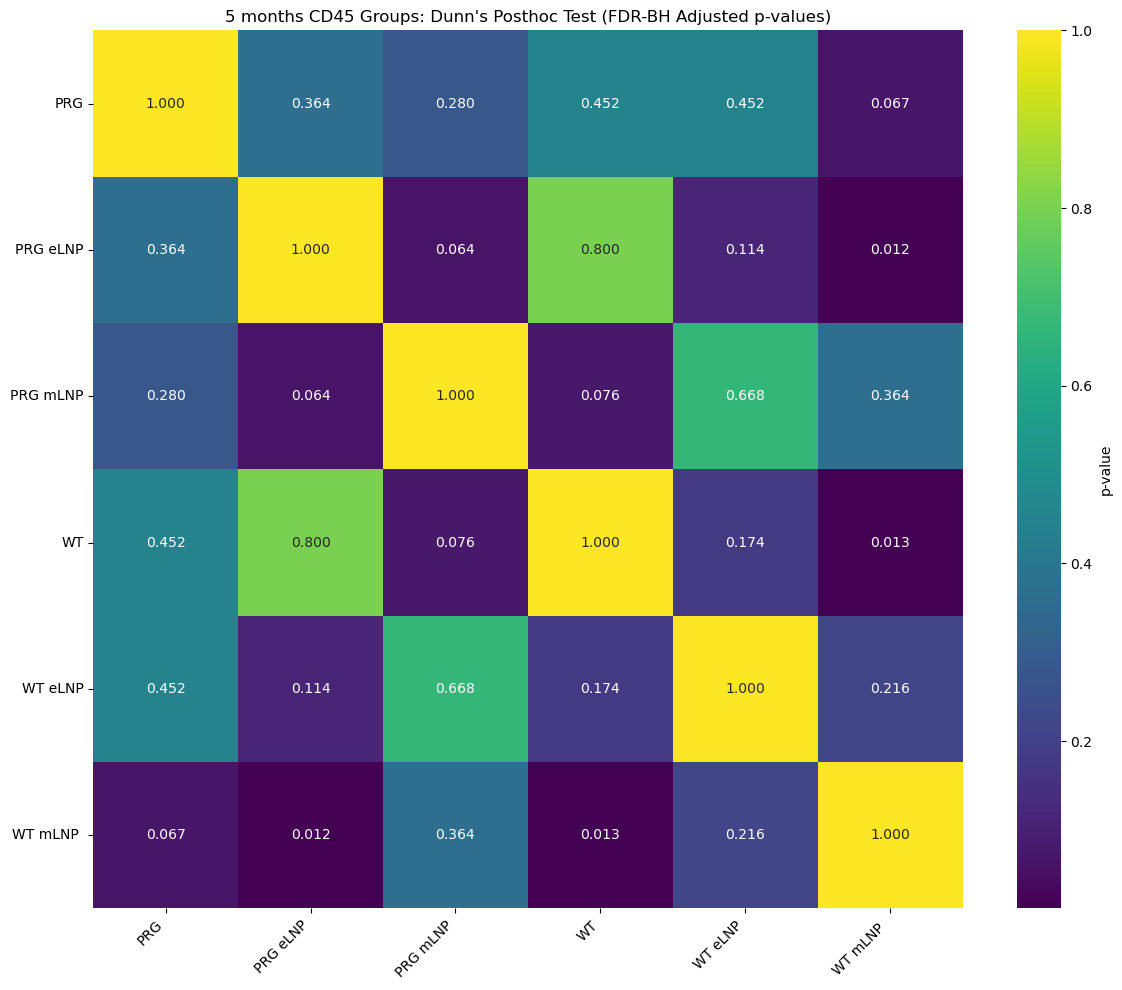

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(cd_5mo_dunn, cmap="viridis", annot=True, fmt=".3f", cbar_kws={'label': 'p-value'})
plt.title("5 months CD45 Groups: Dunn's Posthoc Test (FDR-BH Adjusted p-values)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [36]:
# Statistical test for bGAL, based on groups
import scipy.stats as stats

# Group data by GROUP
bg_mt_grouped = bg_mt.groupby('GROUP')['Normalized'].apply(list)

# Run Kruskal–Wallis test, because data distribution is not normal, use median instead of mean values
stat, p = stats.kruskal(*bg_mt_grouped)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.3g}")


Kruskal-Wallis H-statistic = 23.144, p-value = 0.000317


In [37]:
import scikit_posthocs as sp

# Dunn's test with Benjamini-Hochberg correction
bg_dunn = sp.posthoc_dunn(bg_mt, val_col='Normalized', group_col='GROUP', p_adjust='fdr_bh')


In [38]:
bg_dunn.to_csv("20250710_bGAL_all_dunn_result.csv", index=False)

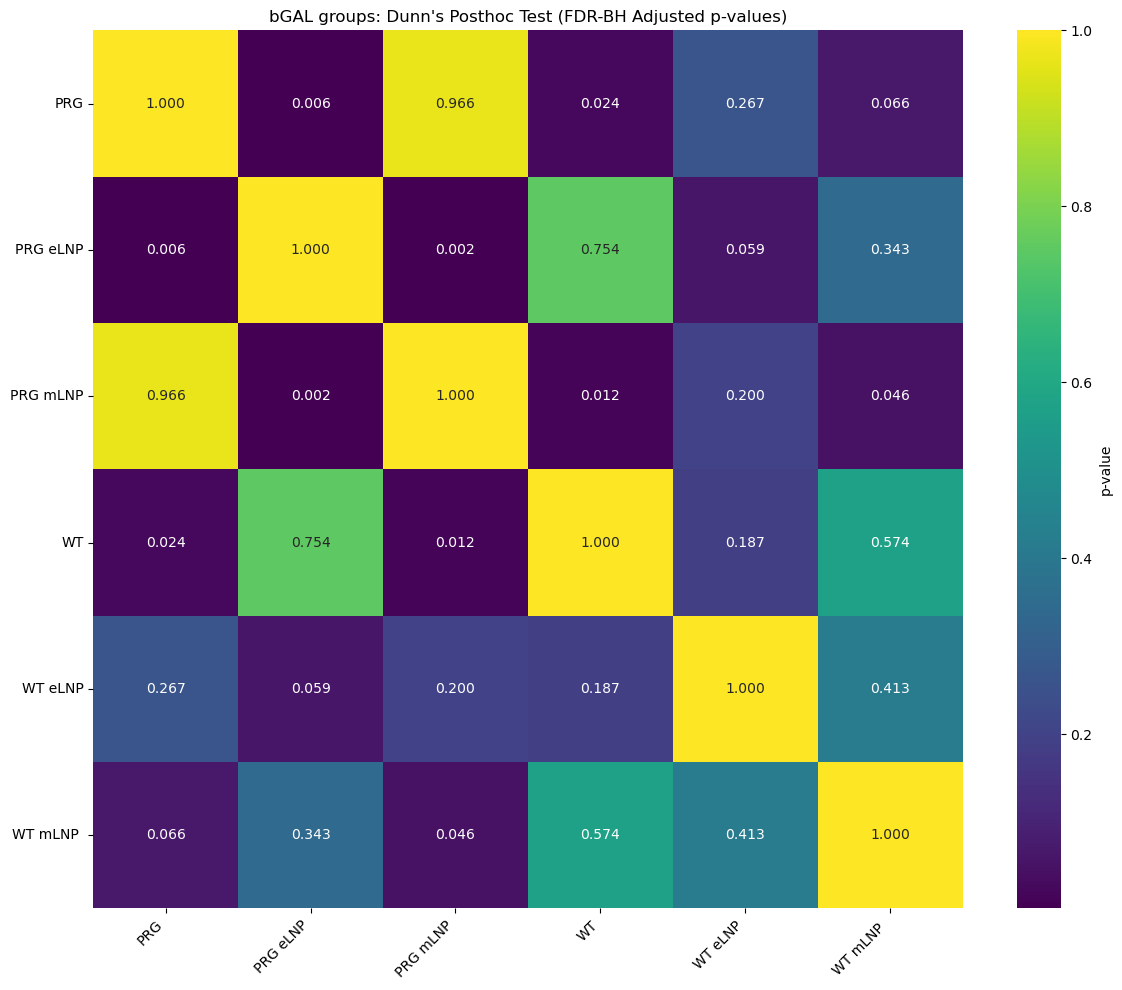

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(bg_dunn, cmap="viridis", annot=True, fmt=".3f", cbar_kws={'label': 'p-value'})
plt.title("bGAL groups: Dunn's Posthoc Test (FDR-BH Adjusted p-values)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:

bg_3mo = bg_mt[bg_mt['INJECTIONS'] == 3.0]
bg_3mo.head(5)


,ImageID,Count,RawIntDen,Normalized,SAMPLE,ROUTE,INJECTIONS,GROUP
27,Image_B_Gal_457_-_20x_BF_02_crop_1,56,NaN,0.0,457,IV,3.0,PRG eLNP
28,Image_B_Gal_457_-_20x_BF_02_crop_2,38,NaN,0.0,457,IV,3.0,PRG eLNP
29,Image_B_Gal_457_-_20x_BF_02_crop_3,41,NaN,0.0,457,IV,3.0,PRG eLNP
30,Image_B_Gal_458_-_20x_BF_02_crop_1,67,NaN,0.0,458,IV,3.0,PRG eLNP
31,Image_B_Gal_458_-_20x_BF_02_crop_2,36,NaN,0.0,458,IV,3.0,PRG eLNP


In [41]:
bg_3mo.to_csv("20250710_3mo_bGAL_normalized.csv", index=False)

In [42]:
# Statistical test for CD45 3 months based on groups
import scipy.stats as stats

# Group data by GROUP
bg_3mo_grouped = bg_3mo.groupby('GROUP')['Normalized'].apply(list)

# Run Kruskal–Wallis test, because data distribution is not normal, use median instead of mean values
stat, p = stats.kruskal(*bg_3mo_grouped)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.3g}")

Kruskal-Wallis H-statistic = 12.483, p-value = 0.0287


In [43]:
import scikit_posthocs as sp

# Dunn's test with Benjamini-Hochberg correction
bg_3mo_dunn = sp.posthoc_dunn(bg_3mo, val_col='Normalized', group_col='GROUP', p_adjust='fdr_bh')


In [44]:
bg_3mo_dunn.to_csv("20250710_bGAL_3mo_dunn_result.csv", index=False)

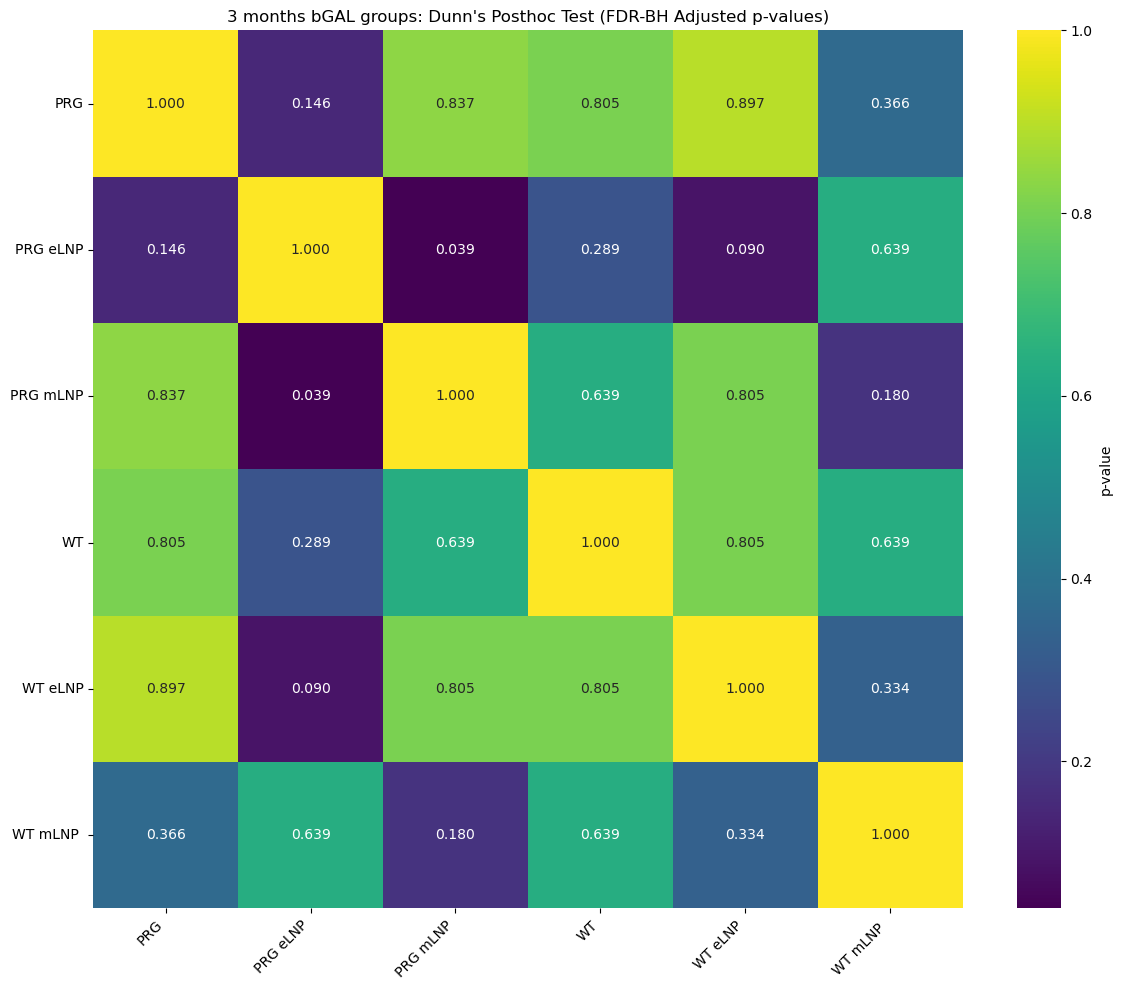

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(bg_3mo_dunn, cmap="viridis", annot=True, fmt=".3f", cbar_kws={'label': 'p-value'})
plt.title("3 months bGAL groups: Dunn's Posthoc Test (FDR-BH Adjusted p-values)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [45]:
bg_5mo = bg_mt[bg_mt['INJECTIONS'] == 5.0]
bg_5mo.head(10)

,ImageID,Count,RawIntDen,Normalized,SAMPLE,ROUTE,INJECTIONS,GROUP
0,Image_B_Gal_416_-_20x_BF_02_crop_1,27,2933010.0,108630.00,416,IV,5.0,PRG mLNP
1,Image_B_Gal_416_-_20x_BF_02_crop_2,52,824670.0,15859.04,416,IV,5.0,PRG mLNP
2,Image_B_Gal_416_-_20x_BF_02_crop_3,0,1115625.0,0.00,416,IV,5.0,PRG mLNP
3,Image_B_Gal_420_-_20x_BF_02_crop_1,71,99450.0,1400.70,420,IV,5.0,WT eLNP
4,Image_B_Gal_420_-_20x_BF_02_crop_2,58,39780.0,685.86,420,IV,5.0,WT eLNP
5,Image_B_Gal_420_-_20x_BF_02_crop_3,65,156315.0,2404.85,420,IV,5.0,WT eLNP
6,Image_B_Gal_428_-_20x_BF_02_crop_1,29,26775.0,923.28,428,IV,5.0,PRG eLNP
7,Image_B_Gal_428_-_20x_BF_02_crop_2,49,237660.0,4850.20,428,IV,5.0,PRG eLNP
8,Image_B_Gal_428_-_20x_BF_02_crop_3,51,150195.0,2945.00,428,IV,5.0,PRG eLNP
9,Image_B_Gal_431_-_20x_BF_02_crop_1,26,5610.0,215.77,431,IV,5.0,WT eLNP


In [47]:
bg_5mo.to_csv("20250710_5mo_bGAL_normalized.csv", index=False)

In [48]:
# Statistical test for CD45 5 months based on groups
import scipy.stats as stats

# Group data by GROUP
bg_5mo_grouped = bg_5mo.groupby('GROUP')['Normalized'].apply(list)

# Run Kruskal–Wallis test, because data distribution is not normal, use median instead of mean values
stat, p = stats.kruskal(*bg_5mo_grouped)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.3g}")

Kruskal-Wallis H-statistic = 16.372, p-value = 0.00586


In [49]:
import scikit_posthocs as sp

# Dunn's test with Benjamini-Hochberg correction
bg_5mo_dunn = sp.posthoc_dunn(bg_5mo, val_col='Normalized', group_col='GROUP', p_adjust='fdr_bh')


In [50]:
bg_5mo_dunn.to_csv("20250710_bGAL_5mo_dunn_result.csv", index=False)

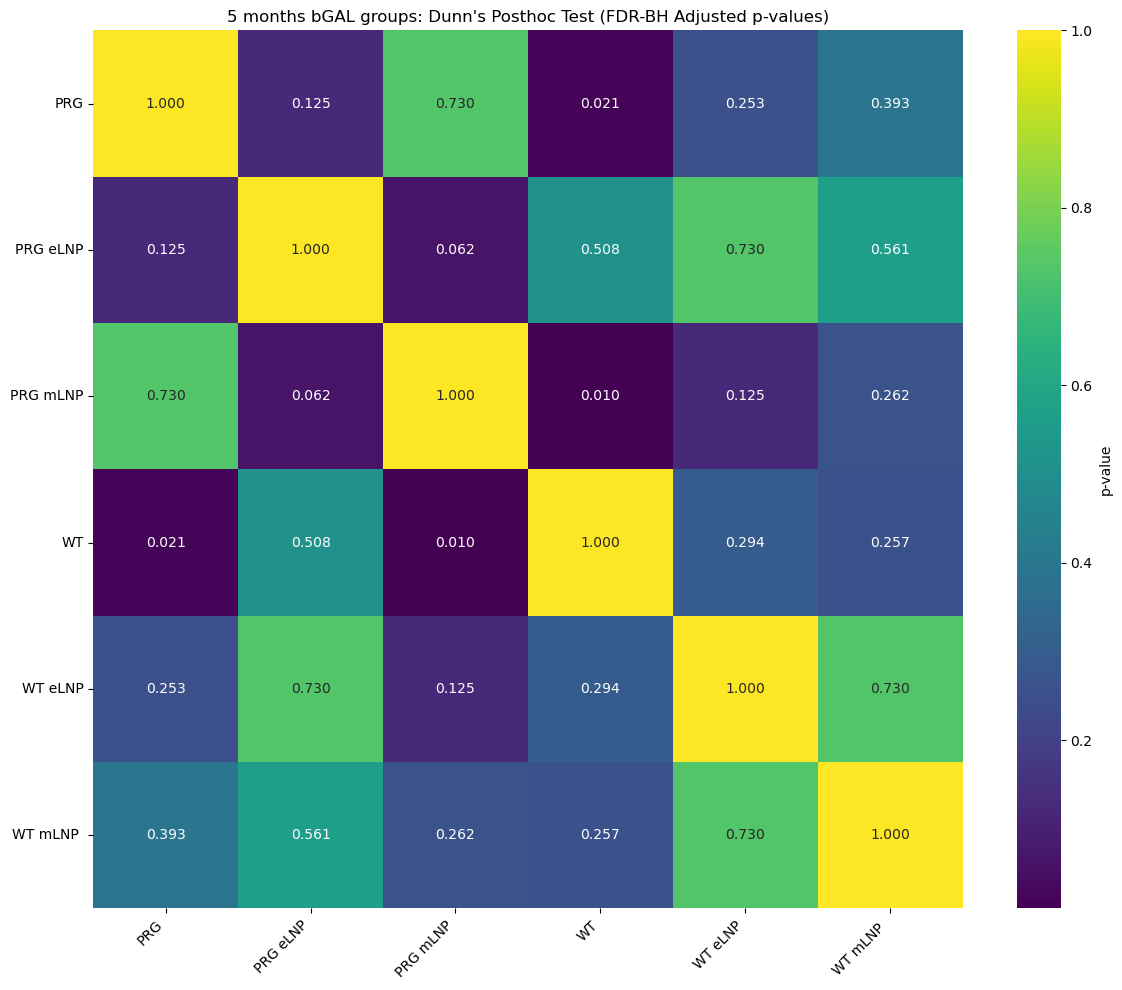

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(bg_5mo_dunn, cmap="viridis", annot=True, fmt=".3f", cbar_kws={'label': 'p-value'})
plt.title("5 months bGAL groups: Dunn's Posthoc Test (FDR-BH Adjusted p-values)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()